<a href="https://colab.research.google.com/github/SageSquash/MTechImageEnhancement/blob/master/Copy_of_untitled22_8th_February.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import numpy as np
from skimage.exposure import histogram


class Histogram:

	def sub_histogram_equalization(self, histogram, range_min = 0, range_max = 255):
		cdf = histogram.cumsum()
		cdf_mask = np.ma.masked_equal(cdf, 0)
	
		# Scale cdf to [range_min, range_max]
		scale_cdf_mask = ((cdf_mask - cdf_mask.min()) * (range_max - range_min) / (cdf_mask.max() - cdf_mask.min())) + range_min
		LUT = np.ma.filled(scale_cdf_mask, 0).astype('uint8')

		return LUT

	def histogram_equalization(self, image_1d, range_min = 0, range_max = 255):
		histogram, _ = np.histogram(image_1d, range_max - range_min + 1, [range_min, range_max])

		return self.sub_histogram_equalization(histogram, range_min, range_max)

	def histogram_equalization_threshold(self, image_1d, threshold, start = 0, end = 255):
		lower_filter = image_1d <= threshold
		lower_1d = image_1d[lower_filter]

		upper_filter = image_1d > threshold
		upper_1d = image_1d[upper_filter]

		lower_input_lut = np.array([])
		if start > 0:
			for i in range(0, start):
				lower_input_lut = np.append(lower_input_lut, i)

		upper_input_lut = np.array([])
		if end < 255:
			for i in range(end + 1, 256):
				upper_input_lut = np.append(upper_input_lut, i)

		lower_LUT = self.histogram_equalization(lower_1d, start, threshold)
		upper_LUT = self.histogram_equalization(upper_1d, threshold + 1, end)

		lower_LUT = np.concatenate((lower_input_lut, lower_LUT))
		upper_LUT = np.concatenate((upper_LUT, upper_input_lut))

		LUT = np.concatenate((lower_LUT, upper_LUT))

		return LUT

	def histogram_equalization_recursively(self, image_1d, separate_func, recursive, start = 0, end = 255):
		if recursive > 0:
			separate = separate_func(image_1d)
			separate = math.floor(separate)

			lower_filter = image_1d <= separate
			lower_1d = image_1d[lower_filter]
			
			lower_equalization = self.histogram_equalization_recursively(lower_1d, separate_func, recursive - 1, start, separate)

			upper_filter = image_1d > separate
			upper_1d = image_1d[upper_filter]

			upper_equalization = self.histogram_equalization_recursively(upper_1d, separate_func, recursive - 1, separate + 1, end)

			return np.concatenate((lower_equalization, upper_equalization))
		else:
			return self.histogram_equalization(image_1d, start, end)


In [3]:
import math
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

class Utils:
	def __init__(self, image, color_space = 'HSV'):
		self.image = image
		self.color_space = color_space

	def image_gray(self):
		if (self.color_space == 'HSV'):
			image_hsv = cv.cvtColor(self.image, cv.COLOR_BGR2HSV)
			self.image_color = image_hsv

			return image_hsv[:, :, 2]
		elif (self.color_space == 'Gray'):
			image_gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
			self.image_color = image_gray

			return image_gray
		else:
			self.image_color = self.image
			return self.image

	def LUT_image(self, LUT):
		if (self.color_space == 'HSV'):
			for i in range(0, len(self.image_color)):
				for j in range(0, len(self.image_color[0])):
					self.image_color[i][j][2] = LUT[self.image_color[i][j][2]]

			return cv.cvtColor(self.image_color, cv.COLOR_HSV2BGR)
		elif (self.color_space == 'Gray'):
			return LUT[self.image_color]
		else:
			return self.image_color

	def is_gray_image(self):
		blue, green, red = cv2.split(self.image)

		difference_red_green = np.count_nonzero(abs(red - green))
		difference_green_blue = np.count_nonzero(abs(green - blue))
		difference_blue_red = np.count_nonzero(abs(blue - red))

		difference_sum = float(difference_red_green + difference_green_blue + difference_blue_red)

		ratio = difference_sum / self.image.size

		if ratio>0.005:
				return False
		else:
				return True

	def minimum_mean_brightness_error(self, image_1d):
		length = len(image_1d)

		unique_1d = np.unique(image_1d)
		max_1d = len(unique_1d)

		histogram, _ = np.histogram(image_1d, 256, [0, 255])

		mean = 0
		for i in range(0, len(unique_1d)):
			mean += i * histogram[unique_1d[i]]

		smbe = max_1d * (length - histogram[unique_1d[0]]) - 2 * mean
		asmbe = abs(smbe)
		position = 0
		for i in range(1, len(unique_1d)):
			smbe += (length - max_1d * histogram[unique_1d[i]])
			if asmbe > abs(smbe):
				asmbe = abs(smbe)
				position = i

		return unique_1d[position]


In [1]:
class IE:
    def __init__(self, image, color_space = 'HSV'):
        self.image = image
        self.color_space = color_space
    
    ########################################
    #
    # Histogram equalization
    #
    ########################################

    #Histogram Equalization
    def GHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        histogram = Histogram()
        LUT = histogram.histogram_equalization(image_1d)
        return utils.LUT_image(LUT)

    # Kim, Yeong-Taeg.
    # Contrast enhancement using brightness preserving bi-histogram equalization. 
    # IEEE transactions on Consumer Electronics 43, no. 1 (1997): 1-8.
    # Brightness-preserving Bi-Histogram Equalization (BBHE)
    def BBHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        mean = np.mean(image_1d)
        mean = math.floor(mean)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, mean)
        return utils.LUT_image(LUT)
    # Chen, Soong-Der, and Abd Rahman Ramli. 
    # Contrast enhancement using recursive mean-separate histogram equalization for scalable brightness preservation.
    # IEEE Transactions on consumer Electronics 49, no. 4 (2003): 1301-1309.
    # Recursive Mean-Separate Histogram Equalization (RMSHE)
    def RMSHE(self, recursive = 2):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        histogram = Histogram()
        LUT = histogram.histogram_equalization_recursively(image_1d, np.mean, recursive)
        return utils.LUT_image(LUT)
    # Chen, Soong-Der, and Abd Rahman Ramli. 
    # Minimum mean brightness error bi-histogram equalization in contrast enhancement.
    # IEEE transactions on Consumer Electronics 49, no. 4 (2003): 1310-1319.
    # Minimum Mean Brightness Error Histogram Equalization (MMBEBHE)
    def MMBEBHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        mbe = utils.minimum_mean_brightness_error(image_1d)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, mbe)
        return utils.LUT_image(LUT)
    # Wang, Yu, Qian Chen, and Baeomin Zhang.
    # Image enhancement based on equal area dualistic sub-image histogram equalization method.
    # IEEE Transactions on Consumer Electronics 45, no. 1 (1999): 68-75.
    # Dualistic Sub-Image Histogram Equalization (DSIHE)
    def DSIHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        median = np.median(image_1d)
        median = math.floor(median)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, median)
        return utils.LUT_image(LUT)
    # Wang, Zhi-Guo, Zhi-Hu Liang, and Chun-Liang Liu. 
    # A real-time image processor with combining dynamic contrast ratio enhancement and inverse gamma correction for PDP.
    # Displays 30, no. 3 (2009): 133-139.
    # Dynamic Contrast Ratio Gamma Correction (DCRGC)
    def DCRGC(self, contrast_intensity, gamma):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        gamma_reverse = [0.0] * 256
        for i in range(1, 256):
            gamma_reverse[i] = (i / 255) ** gamma

        normalized_foundation_histogram = np.array([0.0] * 256)
        for i in range(1, 256):
            normalized_foundation_histogram[i] = gamma_reverse[i] - gamma_reverse[i - 1]

        histogram, _ = np.histogram(image_1d, 256, [0, 255])
        histogram = histogram / len(image_1d)

        normalized_combination_histogram = histogram * contrast_intensity + normalized_foundation_histogram * (1 - contrast_intensity)
        normalized_combination_cdf = normalized_combination_histogram.cumsum()

        LUT = normalized_combination_cdf * 255
        LUT = LUT.astype('uint8')

        return utils.LUT_image(LUT)
    # Huang, Shih-Chia, Fan-Chieh Cheng, and Yi-Sheng Chiu. 
    # Efficient contrast enhancement using adaptive gamma correction with weighting distribution.
    # IEEE transactions on image processing 22, no. 3 (2012): 1032-1041.
    # Adaptive Gamma Correction with Weighting Distribution (AGCWD)
    def AGCWD(self, alpha = 0.5):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()
        length = len(image_1d)

        pdf, _ = np.histogram(image_1d, 256, [0, 255])
        pdf = pdf / length
        highest_probabilitiy = pdf.max()
        lowest_probability = pdf.min()

        weight_distribution = highest_probabilitiy * ((pdf - lowest_probability) / (highest_probabilitiy - lowest_probability)) ** alpha
        weight_distribution_sum = np.sum(weight_distribution)

        weight_distribution_scale = weight_distribution / weight_distribution_sum

        LUT = np.array([0.0] * 256)
        for i in range(0, 256):
            LUT[i] = 255 * (i / 255) ** (1 - weight_distribution_scale[i])
        LUT = LUT.astype('uint8')

        return utils.LUT_image(LUT)
    # Rahman, Shanto, Md Mostafijur Rahman, Mohammad Abdullah-Al-Wadud, Golam Dastegir Al-Quaderi, and Mohammad Shoyaib.
    # An adaptive gamma correction for image enhancement.
    # EURASIP Journal on Image and Video Processing 2016, no. 1 (2016): 1-13.
    # Adaptive Gamma Correction Image Enhancement (AGCIE)
    def AGCIE(self, contrast_threshold = 3):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten() / 255

        mean = np.mean(image_1d)
        std = np.std(image_1d)
        LUT = np.arange(0, 256) / 255

        if std <= 1 / (4 * contrast_threshold):
            gamma = -math.log(std, 2)
        else:
            gamma = math.exp((1 - (mean + std))/2)

        if mean >= 0.5:
            LUT = 255 * (LUT ** gamma)
        else:
            for i in range(0, 256):
                LUT[i] = 255 * (LUT[i] ** gamma / (LUT[i] ** gamma + (1 - LUT[i] ** gamma) * mean ** gamma)) 

        LUT = LUT.astype('uint8')

        return utils.LUT_image(LUT)
    # Gupta, Bhupendra, and Mayank Tiwari. 
    # Minimum mean brightness error contrast enhancement of color images using adaptive gamma correction with color preserving framework.
    # Optik 127, no. 4 (2016): 1671-1676.
    # Adaptive Gamma Correction Color Preserving Framework (AGCCPF)
    def AGCCPF(self, alpha = 0.5):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        pdf, _ = np.histogram(image_1d, 256, [0, 255])

        image_equalization = self.GHE()
        image_equalization_1d = image_equalization.flatten()

        pdf_equalization, _ = np.histogram(image_equalization_1d, 256, [0, 255])

        smooth_pdf = 0.5 * pdf + 0.5 * pdf_equalization
        smooth_pdf_scale = smooth_pdf / np.sum(smooth_pdf)

        cdf = smooth_pdf_scale.cumsum()

        LUT = np.array([0.0] * 256)
        for i in range(0, 256):
            LUT[i] = 255 * (i / 255) ** (1 - cdf[i])
        LUT = LUT.astype('uint8')

        return utils.LUT_image(LUT)
    # Zuo, Chao, Qian Chen, and Xiubao Sui. 
    # Range limited bi-histogram equalization for image contrast enhancement.
    # Optik 124, no. 5 (2013): 425-431.
    # Range Limited Bi-Histogram Equalization (RLBHE)
    def RLBHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        otsu_threshold, _ = cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        otsu_threshold = math.floor(otsu_threshold)

        pdf, _ = np.histogram(image_1d, 256, [0, 255])
        image_mean = 0
        lower_cumulative = 0
        for i in range(0, 256):
            image_mean += i * pdf[i]

            if i <= otsu_threshold:
                lower_cumulative += pdf[i]

        length = len(image_1d)
        image_mean /= length
        lower_cumulative /= length

        a = lower_cumulative
        b = 2 * image_mean - otsu_threshold - (1 - a)
        x_0 = 0
        x_l = 255
        for i in range(0, 500):
            temp = 2 * (a * x_0 + (1 - a) * x_l - b)
            x_0 -= temp * a
            x_l -= temp * (1 - a)

        if x_0 < 0:
            x_0 = 0
        elif x_0 > otsu_threshold:
            x_0 = otsu_threshold
        else:
            x_0 = math.floor(x_0)

        if x_l > 255:
            x_l = 255
        elif x_l <= otsu_threshold:
            x_l = otsu_threshold + 1
        else:
            x_l = math.floor(x_l)

        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, otsu_threshold, x_0, x_l)
        return utils.LUT_image(LUT)

In [32]:
import math
import numpy as np
from math import log2
from skimage.metrics import structural_similarity as ssim

class Quantitation:
  # Absolute Mean Brightness Error
  def AMBE(self, image_input, image_output):
    return abs(np.mean(image_input) - np.mean(image_output))

  # Mean Square Error
  def MSE(self, image_input, image_output):
    # err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
    # err /= float(image_input.shape[0] * image_input.shape[1])
    # return err
    err = 10 * math.log10((255 * 255)/cv2.PSNR(image_input, image_output))
    return err

  # Peak Signal to Noise Ratio
  def PSNR(self, image_input, image_output):
    # return 10 * math.log10((255 * 255) / MSE(image_input, image_output))
    return cv2.PSNR(image_input, image_output)
  
  def SNR(self, image_input, image_output):
    ibg = 0
    signal = ((image_input + image_output) / 2 - ibg).sum()
    f = (0.5 ** 0.5) * ((2 / np.pi) ** -0.5)
    noise = np.abs(image_input - image_output).sum() * f
    snr = signal / noise
    return snr

# # Convert the images to floating point arrays
#     ref = ref.astype(np.float32)
#     test = test.astype(np.float32)

# # Calculate the mean and variance of the pixel values
#     ref_mean = np.mean(ref)
#     test_mean = np.mean(test)
#     ref_var = np.var(ref)
#     test_var = np.var(test)

# # Calculate the SNR
#     snr = 20 * np.log10(np.sqrt(ref_var / test_var))
#     return snr

  def SSIM(self, image_input, image_output):
    # return ssim(image_input, image_output, win_size=1, use_sample_covariance=False)
    return ssim(image_input, image_output,multichannel=True)
  

In [35]:
def discrete_entropy(image):
    # Read the input image in grayscale
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # Convert the image to a 1D array
    img_flat = img.flatten()

    # Calculate the probabilities of each intensity level
    levels, counts = np.unique(img_flat, return_counts=True)
    probabilities = counts / len(img_flat)

    # Calculate the entropy of the image
    entropy = 0
    for i in range(len(levels)):
        p_i = probabilities[i]
        entropy -= p_i * log2(p_i) if p_i != 0 else 0

    return entropy

In [5]:
import numpy as np
from skimage.color import rgb2gray
from skimage.exposure import histogram
import math
def calculate_entropy(image):
  # Convert the image to grayscale
  image = rgb2gray(image)

  # Calculate the histogram of the image
  hist, _ = histogram(image)

  # Normalize the histogram
  hist = hist / hist.sum()

  # Calculate the entropy of the image
  entropy = -sum(p * math.log(p) for p in hist if p != 0)
  
  return entropy

In [6]:
# def MSE(image_input, image_output):
#     err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
#     err /= float(image_input.shape[0] * image_input.shape[1])
#     return (err)

In [9]:
import PIL
import cv2
from PIL import Image
import numpy as np
from IPython.display import display
from numpy import cumsum
import sys
import matplotlib.pyplot as plt
from skimage import io
from google.colab.patches import cv2_imshow
# img1 = cv2.cvtColor(io.imread('https://upload.wikimedia.org/wikipedia/commons/d/d3/PSNR-example-base.png'), cv2.COLOR_RGB2BGR)
# img2 = cv2.cvtColor(io.imread('https://upload.wikimedia.org/wikipedia/commons/2/2a/PSNR-example-comp-90.jpg'), cv2.COLOR_RGB2BGR)
# Taking Input
img3 = cv2.imread('/content/4.2.05.tiff',cv2.IMREAD_COLOR)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

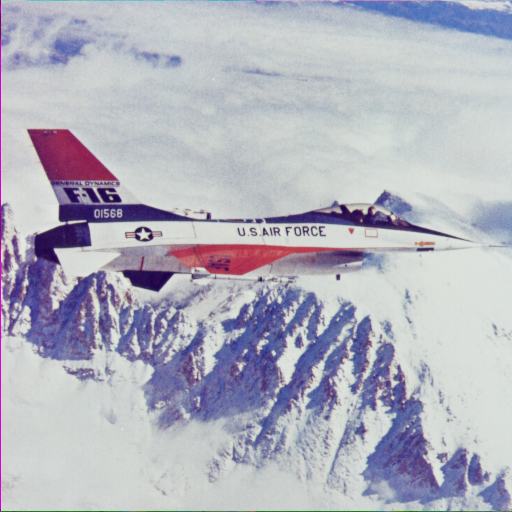

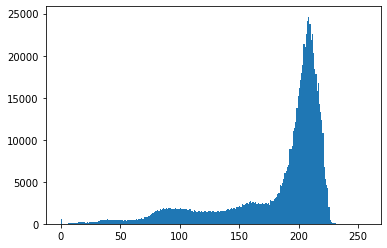

In [10]:
# Original Image
cv2_imshow(img3)
plt.hist(img3.ravel(),256,[0,256]); plt.show()


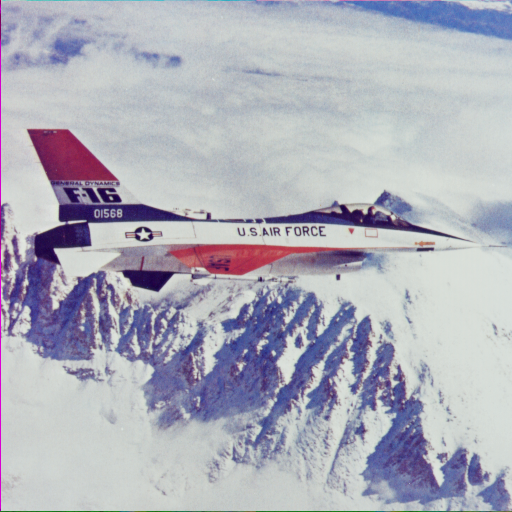

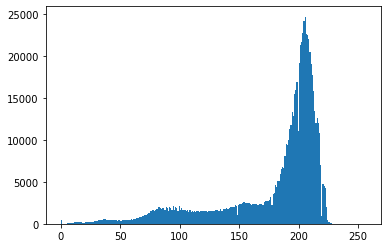

32.510408624919705
36.478712221172444
3.7115478515625
21.55338004316921
0.9977243021781484
4.834974460078612


In [11]:
##Applying AGCIE
check = IE(img3)
img_output = check.AGCIE()
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))
print(q.SSIM(img3,img_output))

In [ ]:
# %pip install sewar
# from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
# rmse(img3,img_output)

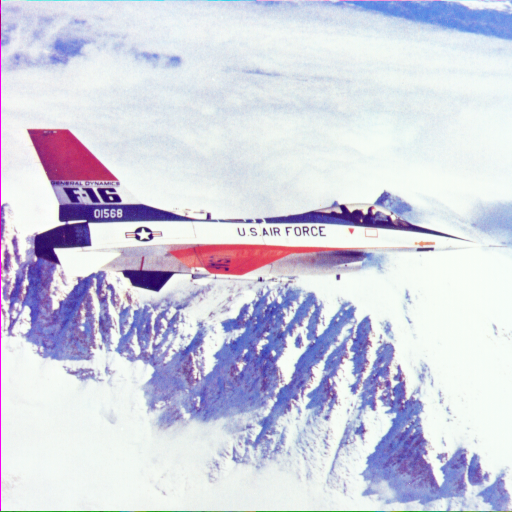

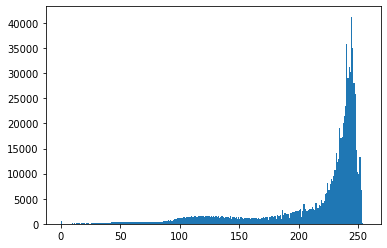

35.63521545524634
17.764738351114513
32.52371597290039
0.42916889320397567
0.9737851119138146
4.5471902912575395


In [12]:
##Applying AGCCPF
check = IE(img3)
img_output = check.AGCCPF()
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

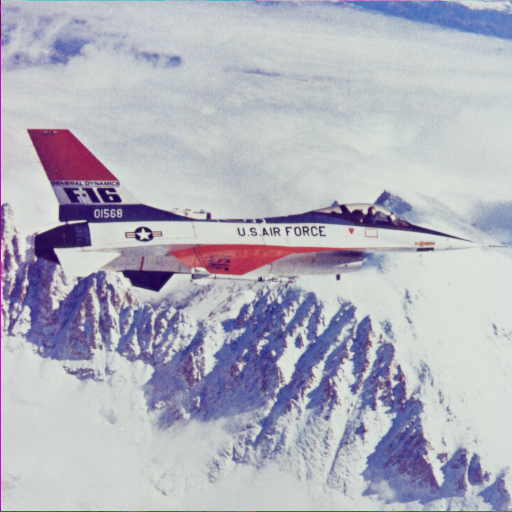

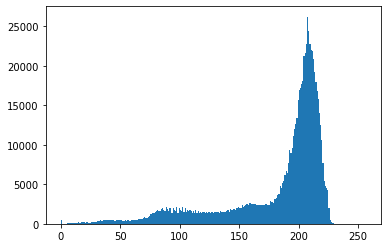

30.938969260291177
52.382163867865465
0.35589853922525094
0.9985905060654011
4.8136569781802026


In [13]:
##Applying AGCWD
check = IE(img3)
img_output = check.AGCWD()
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
# print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

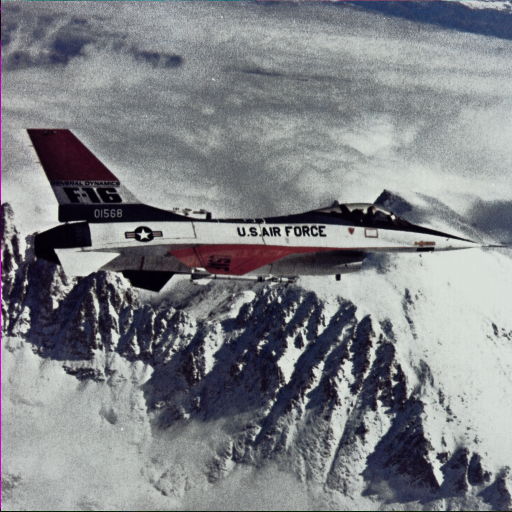

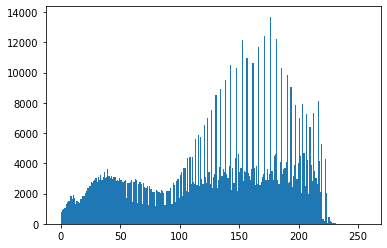

37.05902558224341
12.799051974122582
51.74121983846027
1.3145236719542612
0.668924913743917
5.204299644618999


In [14]:
##Applying DCRGC
check = IE(img3)
img_output = check.DCRGC(0.5,2.2)
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

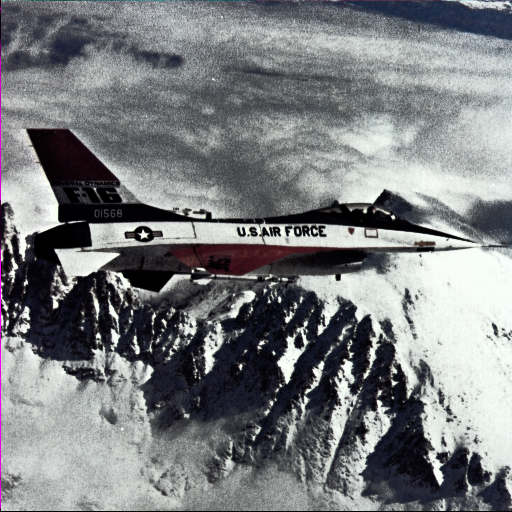

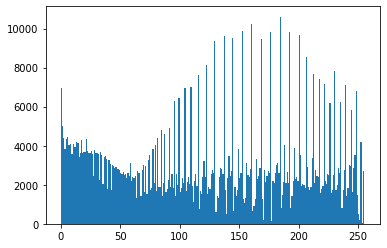

37.76662256022452
10.874720530789045
56.81988779703775
0.7323552391729563
0.4678082983707159
5.097478404308139


In [15]:
# # Applying Histogram equalization
check = IE(img3)
img_output = check.GHE()
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

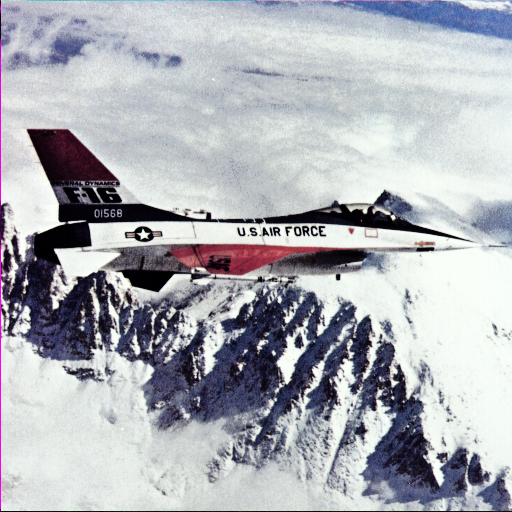

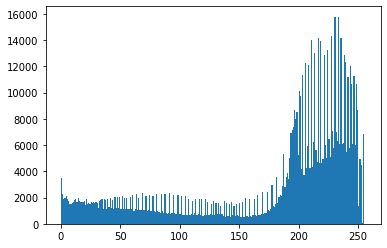

35.668918373835304
17.627410710316596
4.612847646077455
0.5418559131151987
0.8094177767891334
5.07951939370055


TypeError: ignored

In [36]:
# # Applying BBHE
check = IE(img3)
img_output = check.BBHE()
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

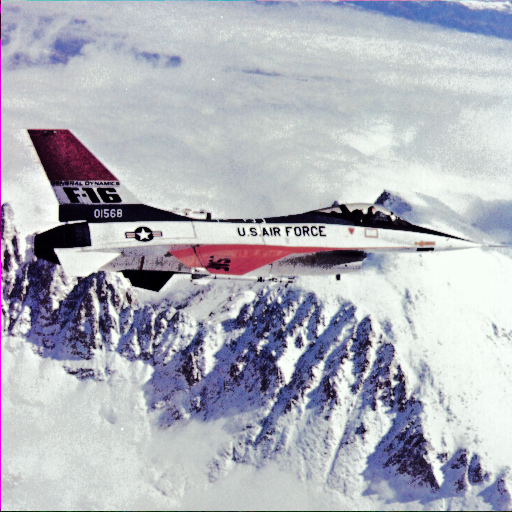

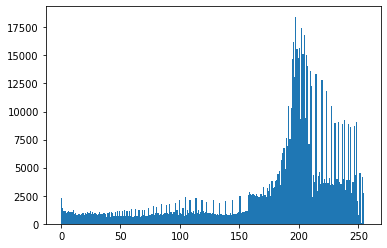

34.65616221965567
22.256872550219242
1.3049456278482978
1.03734141268388
0.876524394750919
4.959328247399705


In [17]:
# # Applying RMSHE
check = IE(img3)
img_output = check.RMSHE()
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

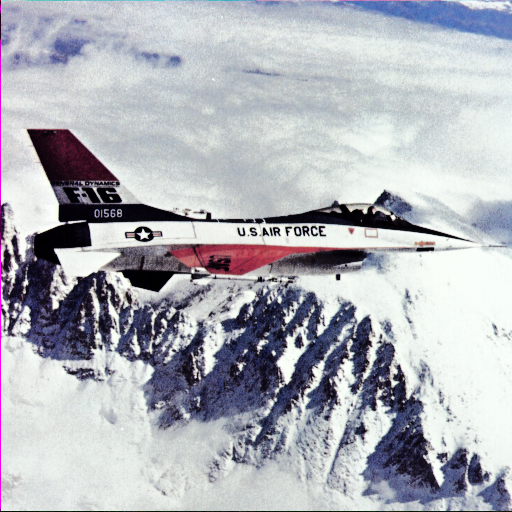

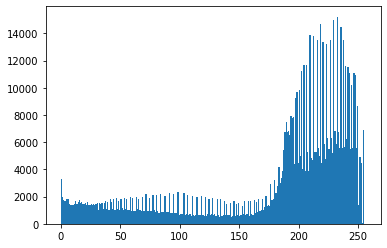

35.459800377662546
18.496958539564766
2.4482269287109375
0.5747250412903795
0.8294779069472455
5.083814256164943


In [18]:
# # Applying MMBEBHE
check = IE(img3)
img_output = check.MMBEBHE()
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

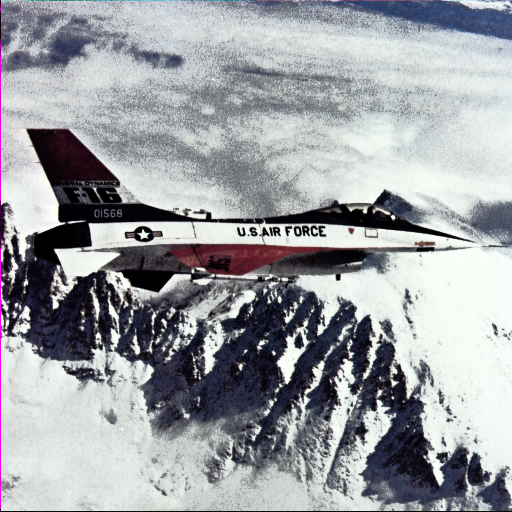

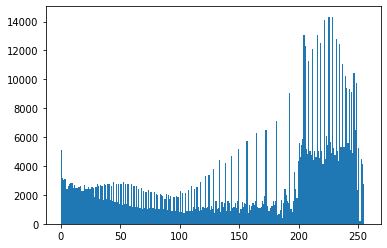

36.55535976942914
14.37289933668379
22.347952524820954
0.5950801458049271
0.6304294453474489
5.189430965594743


In [19]:
# # Applying DSIHE
check = IE(img3)
img_output = check.DSIHE()
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

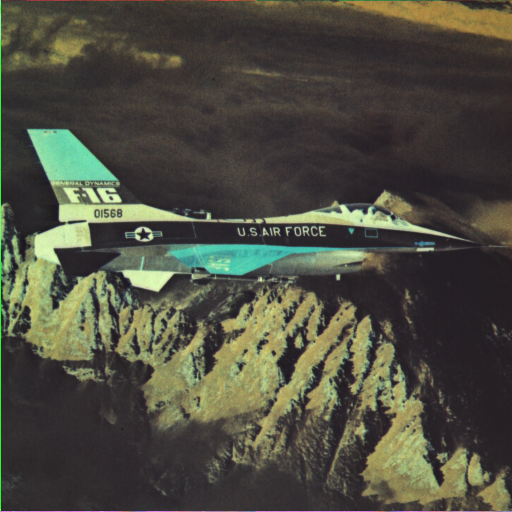

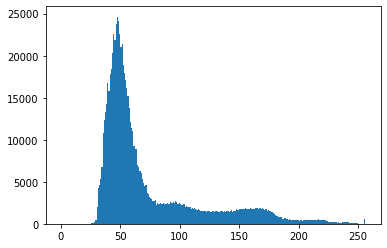

40.95920826113732
5.213862031628084
108.76221974690755
0.9904510251644121
-0.09117675593666802
4.809517655424149


In [20]:
# # Applying Image Invert/Complement
im = np.array(img3)
mask = np.full(im.shape,255)
mod_img = mask - im
img_output = mod_img.astype(np.uint8)
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

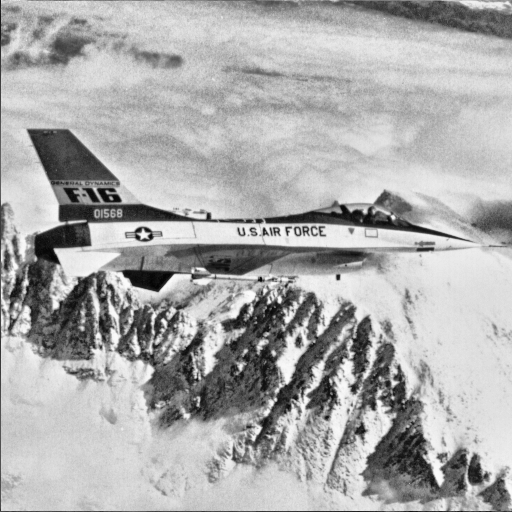

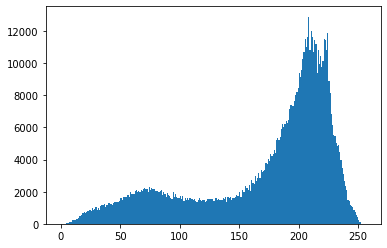

34.505888008289304
23.040481993737615
7.23492431640625
0.8298025900092832
0.8717195468440594
5.123338478092684


In [24]:
# # Applying CLAHE
# Taking Input Image
input_image = cv2.imread('/content/4.2.05.tiff', 0)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
R, G, B = cv2.split(input_image)
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8, 8))
output2_R = clahe.apply(R)
output2_G = clahe.apply(G)
output2_B = clahe.apply(B)
img_output = cv2.merge((output2_R, output2_G, output2_B))
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(input_image,img_output))
print(q.PSNR(input_image,img_output))
print(q.AMBE(input_image,img_output))
print(q.SNR(input_image,img_output))
print(q.SSIM(input_image,img_output))
print(calculate_entropy(img_output))

In [22]:
# #Gamma Correction
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return cv2.LUT(src, table)

Gamma Correction


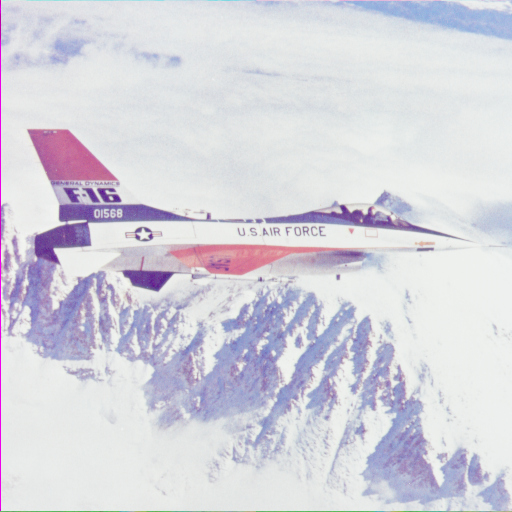

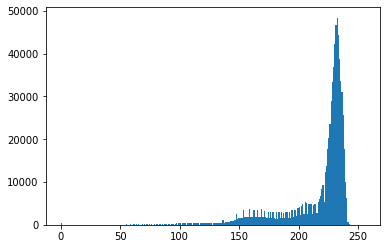

35.91737946700282
16.64724664863791
33.94598642985028
0.407935047173705
0.9178247357112443
4.290852041875753


In [25]:
# Taking Input Image
img = cv2.imread('/content/4.2.05.tiff')
gammaImg = gammaCorrection(img, 2.2)
# print('Original Image')
# cv2_imshow(img)
print('Gamma Correction')
cv2_imshow(gammaImg)
plt.hist(gammaImg.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img,gammaImg))
print(q.PSNR(img,gammaImg))
print(q.AMBE(img,gammaImg))
print(q.SNR(img,gammaImg))
print(q.SSIM(img,gammaImg))
print(calculate_entropy(gammaImg))

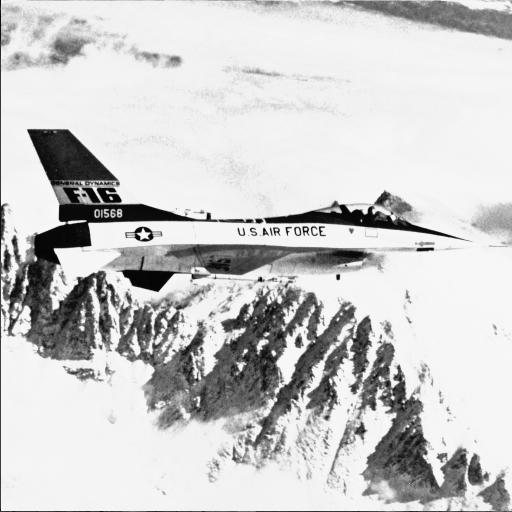

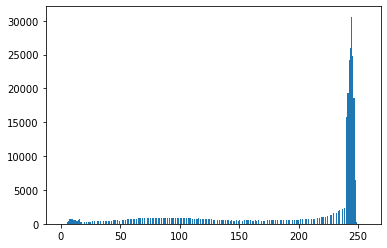

In [26]:
# # Applying Contrast Stretching
img = cv2.imread('/content/4.2.05.tiff',0)
original = img.copy()
xp = [0, 64, 128, 192, 255]
fp = [0, 16, 128, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')
img = cv2.LUT(img, table)
# cv2_imshow(original)
cv2_imshow(img)
plt.hist(img.ravel(),256,[0,256]); plt.show()

In [27]:
q = Quantitation()
print(q.MSE(original,img))
print(q.PSNR(original,img))
print(q.AMBE(original,img))
print(q.SNR(original,img))
print(q.SSIM(original,img))
print(calculate_entropy(img))

35.67851470595026
17.58850353035387
23.435588836669922
0.5318984723262389
0.9059405861585226
3.7157262387568557


<ipython-input-5-2c85a181c7f2>:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = rgb2gray(image)


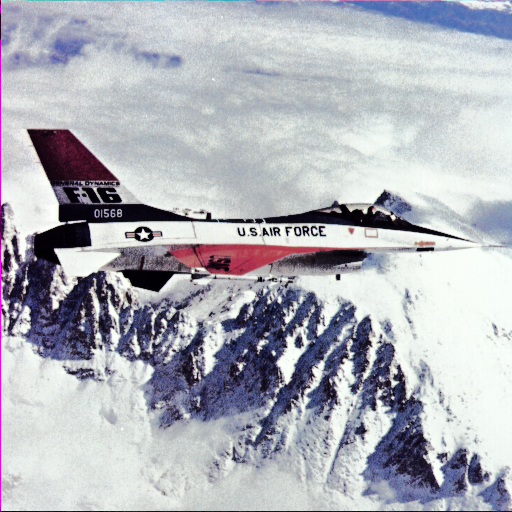

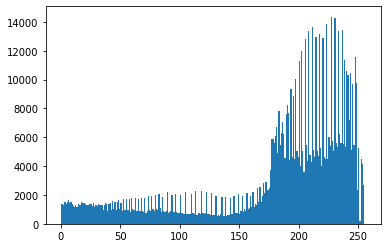

35.213315077923426
19.577122262457635
2.1679153442382812
0.651673256174814
0.8300287219283732
5.108998642397071


In [28]:
# # Applying RLBHE
check = IE(img3)
img_output = check.RLBHE()
cv2_imshow(img_output)
plt.hist(img_output.ravel(),256,[0,256]); plt.show()
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

In [29]:

def tanh_func(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def find_k_opt(pdf_x, lower, upper, mode):
    max_variance = -float('inf')
    k_opt = 0
    r_lower = 0
    r_upper = 0

    if mode == 'u':
        r_lower = -lower
        r_upper = -lower
    else:
        r_lower = 0
        r_upper = 0

    for i in range(lower, upper - 1):
        omega_0 = sum(pdf_x[lower + r_lower + 1 : i + r_lower + 1])
        omega_1 = sum(pdf_x[i + r_lower + 2 : upper + r_lower])
        mu_0 = 0
        if not (omega_0 == 0 or omega_1 == 0):
            for j in range(lower, i + 1):
                if j + r_lower + 1 >= len(pdf_x):
                    break
                mu_0 += (j * pdf_x[j + r_lower + 1]) / omega_0
            mu_1 = 0
            for j in range(i + 1, upper - 1):
                if j + r_lower + 1 >= len(pdf_x):
                    break
                mu_1 += (j * pdf_x[j + r_lower + 1]) / omega_1
            mu = (mu_0 * omega_0) + (mu_1 * omega_1)
            var_x = omega_0 * (mu_0 - mu) ** 2 + omega_1 * (mu_1 - mu) ** 2
            if var_x > max_variance:
                max_variance = var_x
                k_opt = i

    return k_opt

import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import cv2

def mvsihe(x, b_delta):
    L = 256
    m, n = x.shape
    hist_x = np.histogram(x, bins=np.arange(L+1))[0]
    pdf_x = hist_x / (m * n)
    k_op2 = find_k_opt(pdf_x, 0, L, 'g')

    h_sub_1 = hist_x[:k_op2 + 1]
    h_sub_2 = hist_x[k_op2 + 1:]
    
    pdf_sub_1 = h_sub_1 / h_sub_1.sum()
    pdf_sub_2 = h_sub_2 / h_sub_2.sum()
    k_op1 = find_k_opt(pdf_sub_1, 0, k_op2, 'l')
    k_op3 = find_k_opt(pdf_sub_2, k_op2 + 1, L, 'u')
    
    bounds1 = [0, k_op1]
    bounds2 = [k_op1, k_op2]
    bounds3 = [k_op2, k_op3]
    bounds4 = [k_op3, L - 1]
    #there, a few boundary fixes
    h_sub_1 = hist_x[bounds1[0]  : bounds1[1] + 1]
    h_sub_2 = hist_x[bounds2[0] + 1 : bounds2[1] + 1]
    h_sub_3 = hist_x[bounds3[0] + 1 : bounds3[1] + 1]
    h_sub_4 = hist_x[bounds4[0] + 1 : bounds4[1] + 1]

    pdf_sub_1 = h_sub_1 / h_sub_1.sum()
    pdf_sub_2 = h_sub_2 / h_sub_2.sum()
    pdf_sub_3 = h_sub_3 / h_sub_3.sum()
    pdf_sub_4 = h_sub_4 / h_sub_4.sum()

    new_pdf_sub_1 = tanh_func(pdf_sub_1)
    new_pdf_sub_1 = new_pdf_sub_1[:, ~np.all(new_pdf_sub_1 == 0, axis=0)]

    new_pdf_sub_2 = tanh_func(pdf_sub_2)
    new_pdf_sub_2 = new_pdf_sub_2[:, ~np.all(new_pdf_sub_2 == 0, axis=0)]

    new_pdf_sub_3 = tanh_func(pdf_sub_3)
    new_pdf_sub_3 = new_pdf_sub_3[:, ~np.all(new_pdf_sub_3 == 0, axis=0)]

    new_pdf_sub_4 = tanh_func(pdf_sub_4)
    new_pdf_sub_4 = new_pdf_sub_4[:, ~np.all(new_pdf_sub_4 == 0, axis=0)]



    cdf_sub_1 = np.matmul(new_pdf_sub_1.T, np.triu(np.ones((new_pdf_sub_1.shape[0], new_pdf_sub_1.shape[0]))))
    cdf_sub_2 = np.matmul(new_pdf_sub_2.T, np.triu(np.ones((new_pdf_sub_2.shape[0], new_pdf_sub_2.shape[0]))))
    cdf_sub_3 = np.matmul(new_pdf_sub_3.T, np.triu(np.ones((new_pdf_sub_3.shape[0], new_pdf_sub_3.shape[0]))))
    cdf_sub_4 = np.matmul(new_pdf_sub_4.T, np.triu(np.ones((new_pdf_sub_4.shape[0], new_pdf_sub_4.shape[0]))))


    # # histogram equilization method
    ### you got the error in the loop because you need to add squeeze, because of the operations above. It produces a jagged np array therefore we need to reduce it by squeezing.
    fx_sub_1 = (bounds1[0] + ((bounds1[1] - bounds1[0])) * cdf_sub_1).squeeze()
    fx_sub_2 = (bounds2[0] + ((bounds2[1] - bounds2[0])) * cdf_sub_2).squeeze()
    fx_sub_3 = (bounds3[0] + ((bounds3[1] - bounds3[0])) * cdf_sub_3).squeeze()
    fx_sub_4 = (bounds4[0] + ((bounds4[1] - bounds4[0])) * cdf_sub_4).squeeze()

    m, n = x.shape
    out = np.zeros((m, n), dtype=np.uint8)

    # ## I am getting error in this loop
    # in addition, need to add -1 for true boundary values. from matlab to python it changes a bit
    for i in range(L):
        if i <= bounds1[1]:
            out[x == i] = (fx_sub_1[i])
        elif bounds1[1] < i <= bounds2[1]:
            out[x == i] = fx_sub_2[i - bounds2[0]-1]
        elif bounds2[1] < i <= bounds3[1]:
            out[x == i] = fx_sub_3[i - bounds3[0]-1]
        elif bounds3[1] < i <= bounds4[1]:
            out[x == i] = fx_sub_4[i - bounds4[0]-1]

    #############


    # # Normalisation Phase
    ### changed min(min()) to min(), it is enough for a gray image. for max too
    L_min = out.min()
    L_max = out.max()
    T_L = ((out.astype(float) - L_min) / (L_max - L_min)) * 255
    PCR_img = b_delta * T_L + (1 - b_delta) * x.astype(float)
    out = PCR_img.astype(np.uint8)


    out = np.array(out, dtype='uint8') # converting out to a numpy array
    cv2_imshow(out)
    cv2.imwrite("enhanced_image.jpg", out)
    # plt.imshow(out, cmap='gray') # display the image using imshow()
    # plt.show()

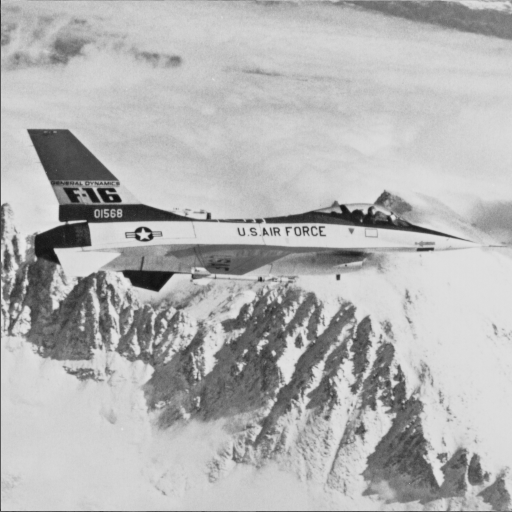

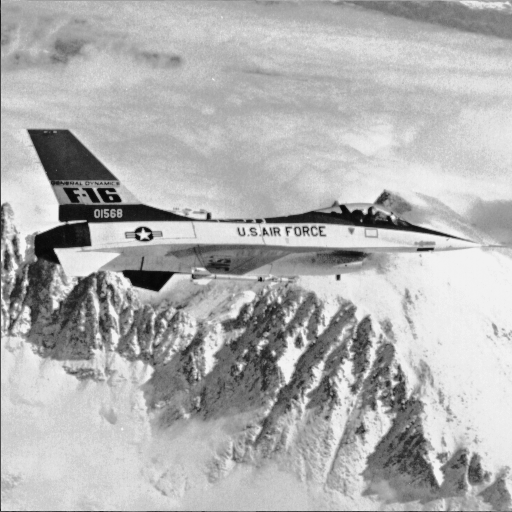

In [30]:
import cv2

# Load image
# a few fixes for my own drive (permissions)
# from google.colab import drive
# drive.mount('/content/drive')
img = cv2.imread('/content/4.2.05.tiff', cv2.IMREAD_GRAYSCALE)

from google.colab.patches import cv2_imshow
cv2_imshow(img)


mvsihe(img,0.6)

In [31]:
img_output = cv2.imread("/content/enhanced_image.jpg", cv2.IMREAD_GRAYSCALE)
q = Quantitation()
print(q.MSE(img,img_output))
print(q.PSNR(img,img_output))
print(q.AMBE(img,img_output))
print(q.SNR(img,img_output))
print(q.SSIM(img,img_output))
print(calculate_entropy(img_output))

33.73700682916684
27.502975246690383
2.4283981323242188
0.8215965961314599
0.9180869590261433
5.105962627531305


<ipython-input-5-2c85a181c7f2>:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = rgb2gray(image)


In [ ]:
# import numpy as np

# image = cv2.imread('/content/Y13.jpg',0) ## input orignal image
# mean_image = np.mean(image)

# noisy_image = cv2.imread('/content/download.png',0) ## input noisy image
# noise = noisy_image - image
# mean_noise = np.mean(noise)
# noise_diff = noise - mean_noise
# var_noise = np.sum(np.mean(noise_diff**2)) ## variance of noise

# if var_noise == 0:
#       snr = 100 ## clean image
# else:
#       snr = (np.log10(mean_image/var_noise))*20 ## SNR of the image
      
# snr

In [ ]:
# import numpy as np
# from scipy import ndimage
# from scipy import signal
# def mse(vref, vcmp):
#     """
#     Compute Mean Squared Error (MSE) between two images.

#     Parameters
#     ----------
#     vref : array_like
#       Reference image
#     vcmp : array_like
#       Comparison image

#     Returns
#     -------
#     x : float
#       MSE between `vref` and `vcmp`
#     """

#     if np.iscomplexobj(vref) or np.iscomplexobj(vcmp):
#         dtype = np.complex128
#     else:
#         dtype = np.float64
#     r = np.asarray(vref, dtype=dtype).ravel()
#     c = np.asarray(vcmp, dtype=dtype).ravel()
#     return np.mean(np.abs(r - c)**2)

In [ ]:
# def snr(vref, vcmp):
#     """
#     Compute Signal to Noise Ratio (SNR) of two images.

#     Parameters
#     ----------
#     vref : array_like
#       Reference image
#     vcmp : array_like
#       Comparison image

#     Returns
#     -------
#     x : float
#       SNR of `vcmp` with respect to `vref`
#     """

#     dv = np.var(vref)
#     with np.errstate(divide='ignore'):
#         rt = dv / q.MSE(vref, vcmp)
#     return 10.0 * np.log10(rt)

In [ ]:
# def SNR(image, image_bruitee):
#     puissanceBrui = 0
#     puissanceSign = 0
#     for i in range(image.shape[0]):
#         for j in range(image.shape[1]):
#             puissanceSign = puissanceSign + (image[i,j])**2
#     for i in range(image_bruitee.shape[0]):
#         for j in range(image_bruitee.shape[1]):
#            puissanceBrui = puissanceBrui + (image_bruitee[i,j] - image[i,j])**2     #Puissance du bruit = image bruité - image de base
#     print("Bruit : "+str(puissanceBrui))
#     print("Signal : "+str(puissanceSign))
#     return "SNR : "+str(10*np.log(puissanceSign/puissanceBrui))